# Real Data, Model 0
**Root notebook: [Microbial_Scaling_Laws](../Microbial_Scaling_Laws.ipynb)**

In [ ]:
import math
import numpy as np
from scipy import stats
#import sympy as smp
from pynverse import inversefunc
import pandas as pd
# from sympy.abc import t, a, b, c, d, e
import emcee
import scipy as scp
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns

from Fernando_package import functions
from Fernando_package import plot_funcs


In [ ]:
df_microbial_growth = pd.read_csv('../data/modified_Susman18_physical_units.csv')
xb_realdata = df_microbial_growth['length_birth'][0]

# remove first NaN
df_microbial_growth  =  df_microbial_growth[~ np.isnan(df_microbial_growth['division_ratio'])]

# check that there is only one cell in the dataset
print('Number of cells in the dataset:', df_microbial_growth['lineage_ID'].nunique()) 

display(df_microbial_growth)
size = len(df_microbial_growth['generationtime'])

Number of cells in the dataset: 1


div_and_fold  fold_growth  division_ratio  added_length  generationtime  \
1        1.009831     0.794984        0.456028      3.198324        0.500000   
2        0.862482     0.607893        0.469619      2.291172        0.416667   
3        1.426486     1.037370        0.505526      4.632409        0.833333   
4        0.729601     0.490156        0.446903      2.028413        0.333333   
5        0.887982     0.609464        0.482744      2.121432        0.416667   
..            ...          ...             ...           ...             ...   
247      0.940427     0.590789        0.520893      2.192641        0.416667   
248      0.928602     0.604227        0.507478      2.069835        0.500000   
249      1.568073     1.046815        0.550478      4.644408        0.750000   
250      0.809727     0.481681        0.500204      2.215210        0.333333   
251      0.860970     0.711011        0.422863      2.538870        0.500000   

     length_birth  length_final  growth_rate  lineage_ID  generation  \
1        2.633655      5.831979     1.589968        15.0         1.0   
2        2.738808      5.029980     1.458944        15.0         2.0   
3        2.542786      7.175195     1.244844        15.0         3.0   
4        3.206619      5.235033     1.470468        15.0         4.0   
5        2.527183      4.648614     1.462714        15.0         5.0   
..            ...           ...          ...         ...         ...   
247      2.722385      4.915026     1.417893        15.0       249.0   
248      2.494268      4.564104     1.208453        15.0       250.0   
249      2.512440      7.156848     1.395754        15.0       251.0   
250      3.579885      5.795095     1.445043        15.0       252.0   
251      2.450531      4.989402     1.422022        15.0       253.0   

     start_time    end_time  
1      1.083333    1.583333  
2      1.666667    2.083333  
3      2.166667    3.000000  
4      3.083333    3.416667  
5      3.500000    3.916667  
..          ...         ...  
247  150.583333  151.000000  
248  151.083333  151.583333  
249  151.666667  152.416667  
250  152.500000  152.833333  
251  152.916667  153.416667  

[251 rows x 12 columns]

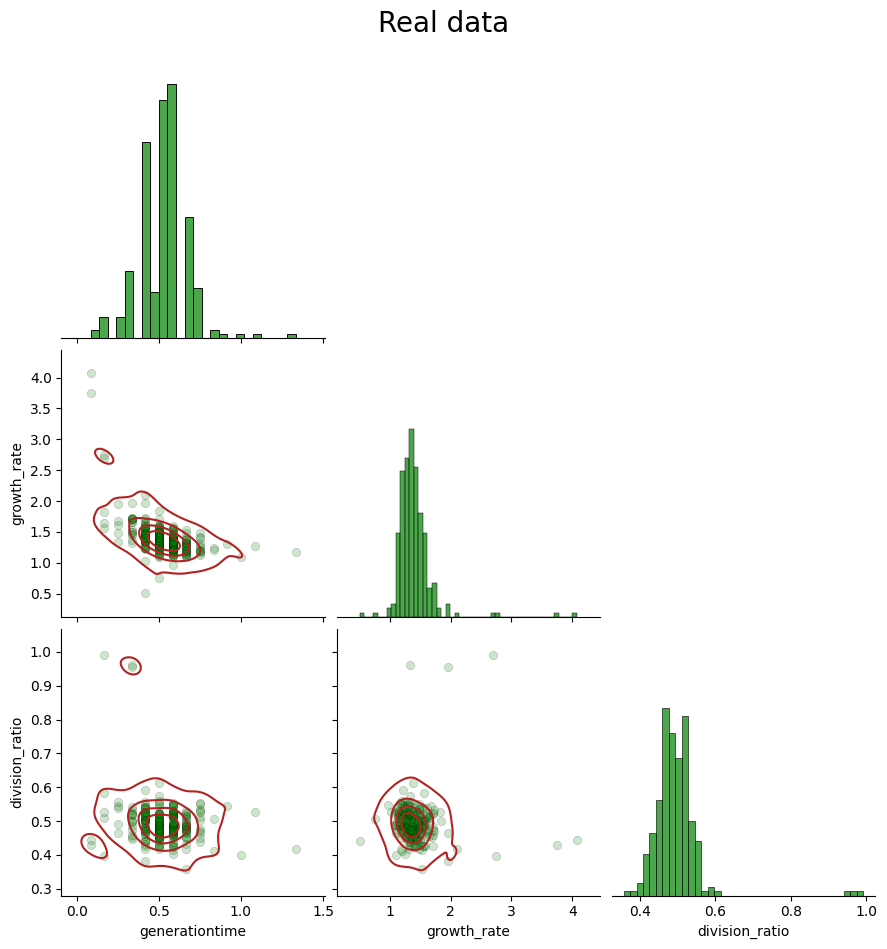

In [ ]:
g = sns.pairplot(
    df_microbial_growth[['generationtime', 'growth_rate', 'division_ratio']], diag_kind="hist", corner=True, 
    plot_kws={'color':'green', 'edgecolor':'black', 'alpha':0.2}, diag_kws={'color':'green', 'alpha':0.7}, height=3
)
g.map_lower(sns.kdeplot, levels=5, color="firebrick")

plt.savefig('../images/pairplot_realdata.png')

g.fig.suptitle('Real data', y=1.05, fontsize=20)
plt.show() 



## Estimate the distribution of $\omega_1$ and frac $f$ from real data

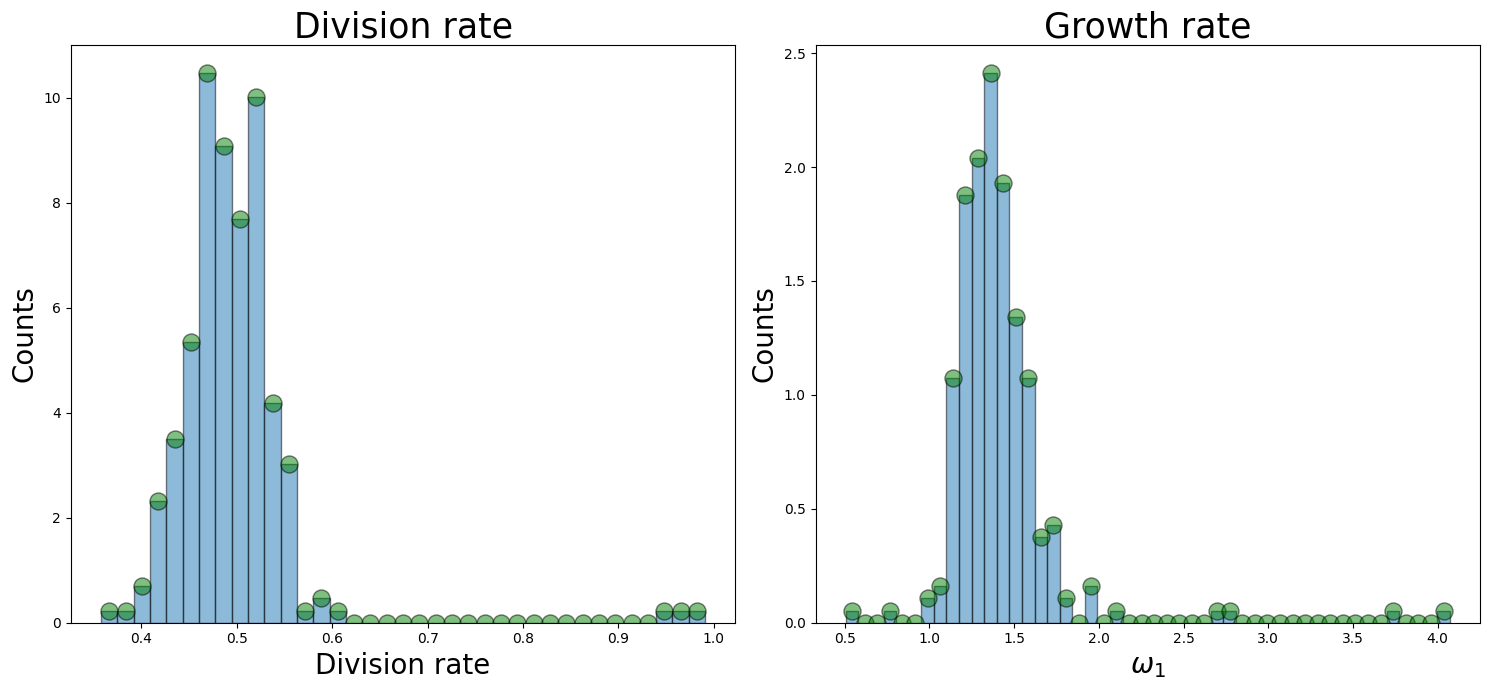

In [ ]:
fig, ax = plt.subplots(1,2 , figsize=(15, 7))

hist_val_div = ax[0].hist(df_microbial_growth['division_ratio'], bins='fd', edgecolor='black', alpha=0.5, density=True)
div_centers = (hist_val_div[1][:-1] + hist_val_div[1][1:]) / 2
ax[0].scatter(div_centers, hist_val_div[0], s=150, color='green', alpha=0.5, edgecolor='black')
ax[0].set_xlabel('Division rate', fontsize=20)
ax[0].set_ylabel('Counts', fontsize=20)
ax[0].set_title('Division rate', fontsize=25)

hist_val_grow = ax[1].hist(df_microbial_growth['growth_rate'], bins='fd', edgecolor='black', alpha=0.5, density=True)
grow_centers = (hist_val_grow[1][:-1] + hist_val_grow[1][1:]) / 2
ax[1].scatter(grow_centers, hist_val_grow[0], s=150, color='green', alpha=0.5, edgecolor='black')
ax[1].set_xlabel('$\\omega_1$', fontsize=20)
ax[1].set_ylabel('Counts', fontsize=20)
ax[1].set_title('Growth rate', fontsize=25)

fig.tight_layout()

In [ ]:
def fit_beta(x, a, b):
    return(scp.stats.beta.pdf(x, a=a,b=b))

def fit_gamma(x, a, teta):
    return(scp.stats.gamma.pdf(x, a=a, scale=teta))

popt_b, pcov_b = scp.optimize.curve_fit(fit_beta, xdata=div_centers, ydata = hist_val_div[0])
popt_g, pcov_g = scp.optimize.curve_fit(fit_gamma, xdata=grow_centers, ydata = hist_val_grow[0])

a_beta  = popt_b[0]; b_beta  = popt_b[1]
c_gamma = popt_g[0]; d_gamma = popt_g[1]

print('The parameters found for the beta distribution are:')
print('a =', np.round(a_beta,1),'+-', np.round(np.sqrt(pcov_b)[0,0],1))
print('b =', np.round(b_beta,1),'+-', np.round(np.sqrt(pcov_b)[1,1],1))

print('\nThe parameters found for the gamma distribution are:')
print('c =', np.round(c_gamma,1),'+-', np.round(np.sqrt(pcov_g[0,0]),1))
print('d =', np.round(d_gamma,3),'+-', np.round(np.sqrt(pcov_g[1,1]),3))


The parameters found for the beta distribution are:
a = 76.6 +- 6.0
b = 79.6 +- 6.2

The parameters found for the gamma distribution are:
c = 63.8 +- 2.6
d = 0.021 +- 0.001


Notice that the values of the parameters $a$ and $b$ of the Beta distribution are very close to each other and as expected the distribution is almost centered around $0.5$.

## Priors
We start by defining the prior distributions of our set of parameters $\underline{\theta}$. 

In [ ]:
def prior_omega2(omega2):
    return(stats.lognorm.pdf(omega2, s=np.sqrt(1/3 - np.log(0.9)), loc=0, scale=np.exp(1/3)))

def prior_mu_nu(mu, nu):
    if mu>=nu:
        return(-np.inf)
    else:
        return(np.log(stats.beta.pdf(mu, a=2, b=5))+np.log(stats.lognorm.pdf(nu, s=1/3, loc=0.1, scale=np.exp(1/9))))

def prior_a(a):
    return(stats.norm.pdf(a, loc=a_beta, scale=10*np.sqrt(10*pcov_b[0,0])))    #a for frac beta pdf

def prior_b(b):
    return(stats.norm.pdf(b, loc=b_beta, scale=10*np.sqrt(pcov_b[1,1])))    #b for frac beta pdf

def prior_c(c):
    return(stats.norm.pdf(c, loc=c_gamma, scale=10*np.sqrt(pcov_g[0,0])))   #c for w1 gamma pdf

def prior_d(d):
    return(stats.norm.pdf(d, loc=d_gamma, scale=10*np.sqrt(pcov_g[1,1])))   #d for w1 gamma pdf

priors = {
    'mu_nu': prior_mu_nu,
    'omega2': prior_omega2,
    'a': prior_a, 
    'b': prior_b, 
    'c': prior_c, 
    'd': prior_d
}

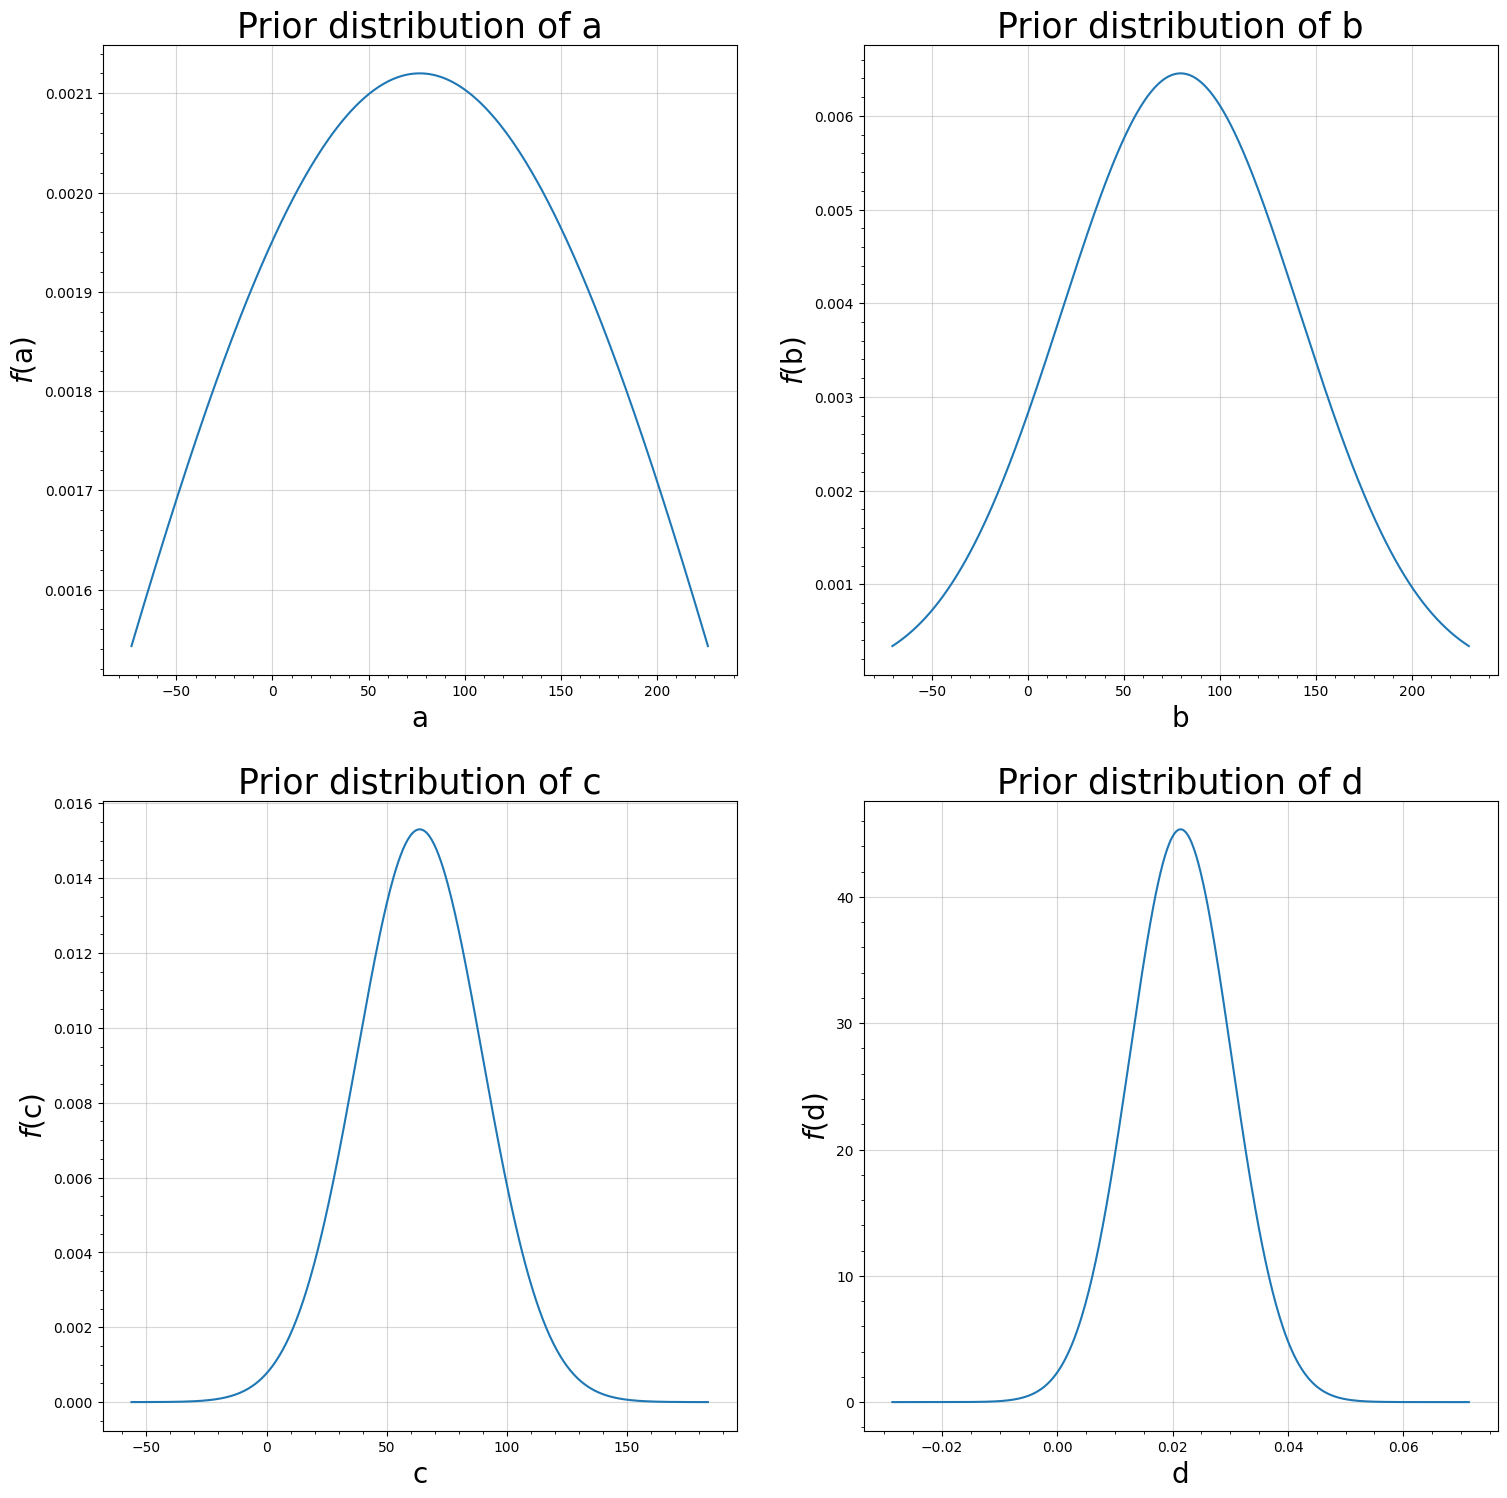

In [ ]:
# plot the prior distributions of a, b, c, d
x_a_ = np.linspace(a_beta-150, a_beta+150, 500)
x_b_ = np.linspace(b_beta-150, b_beta+150, 500)
x_c_ = np.linspace(c_gamma-120, c_gamma+120, 500)
x_d_ = np.linspace(d_gamma-0.05, d_gamma+0.05, 500)

_, ax = plt.subplots(2, 2, figsize=(18, 18))
ax[0, 0].plot(x_a_, prior_a(x_a_))
ax[0, 1].plot(x_b_, prior_b(x_b_)) 
ax[1, 0].plot(x_c_, prior_c(x_c_)) 
ax[1, 1].plot(x_d_, prior_d(x_d_))

param_str = [['a', 'b'], ['c', 'd']]

for i in range(2):
    for j in range(2):
        ax[i, j].set_title('Prior distribution of ' + param_str[i][j], fontsize=25)
        ax[i, j].set_xlabel(param_str[i][j], fontsize=20)
        ax[i, j].set_ylabel('$f($'+param_str[i][j]+'$)$', fontsize=20)
        ax[i, j].minorticks_on()
        ax[i, j].grid(alpha=0.5)

## EMCEE

In [ ]:
n_walkers = 20
np.random.seed(29071981)

# initial state
p0_omega_2 =np.random.uniform(low=0.5, high=1.2, size=n_walkers).reshape(-1, 1)
p0_mu = np.random.uniform(low=0.01, high=0.15, size=n_walkers).reshape(-1, 1)
p0_nu = np.random.uniform(low=0.6, high=1.3, size=n_walkers).reshape(-1, 1)
p0_a = np.random.uniform(low=a_beta, high=a_beta+np.sqrt(pcov_b[0,0]), size=n_walkers).reshape(-1,1)
p0_b = np.random.uniform(low=b_beta , high=b_beta+np.sqrt(pcov_b[1,1]), size=n_walkers).reshape(-1,1)
p0_c = np.random.uniform(low=c_gamma , high=c_gamma+np.sqrt(pcov_g[0,0]), size=n_walkers).reshape(-1,1)
p0_d = np.random.uniform(low=d_gamma , high=d_gamma+np.sqrt(pcov_g[1,1]), size=n_walkers).reshape(-1,1)

p0 = np.hstack([p0_omega_2, p0_mu, p0_nu, p0_a, p0_b, p0_c, p0_d])

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# emcee, using real data
sampler = emcee.EnsembleSampler(
    n_walkers, 7, functions.j_log_unnorm_posterior_emcee_2, 
    kwargs={'y_times': np.array(df_microbial_growth['generationtime']), 
            'frac': np.array(df_microbial_growth['division_ratio']), 
            'omega_1': np.array(df_microbial_growth['growth_rate']), 
            'PDF': functions.PDF, 
            'h_func' : functions.h_start,
            'cdf_func' : functions.CDF_start,
            'xb': np.array(df_microbial_growth['length_birth']),
            'priors': priors}, 
    a=2
)
burn_in = 1700
n_steps = 5000

# burn-in 
pos, prob, state = sampler.run_mcmc(p0, burn_in)
sampler.reset()

# run mcmc
sampler.run_mcmc(pos, n_steps, rstate0=state)

# get chains
chain_start_sim = sampler.get_chain(flat=True)


## Results

Median value of  $\omega_2$ : 2.5107
Max value of  $\omega_2$  : 2.5461
Credibility interval of  $\omega_2$  : [ 0.4402 , 3.4132 ]


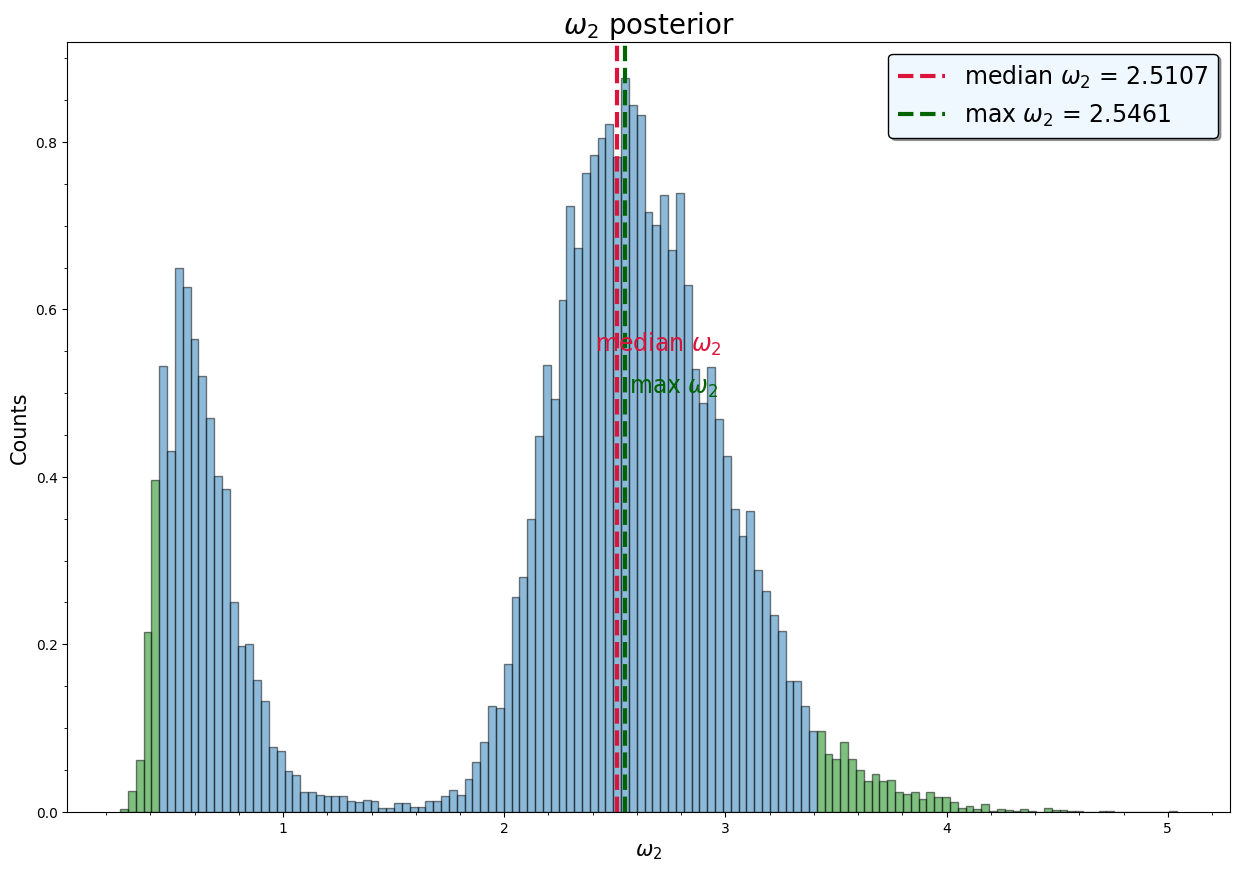

In [ ]:
fig, ax, centers_omega2_s_r, counts_omega2_s_r, max_omega2, ci_low_omega2, ci_high_omega2 = plot_funcs.plot_func_sim(
    chain = chain_start_sim, parameter = 'omega_2', y_max=0.5, y_median=0.55, info=False
)

Median value of  $\mu$ : 0.6775
Max value of  $\mu$  : 0.6949
Credibility interval of  $\mu$  : [ 0.0897 , 0.856 ]


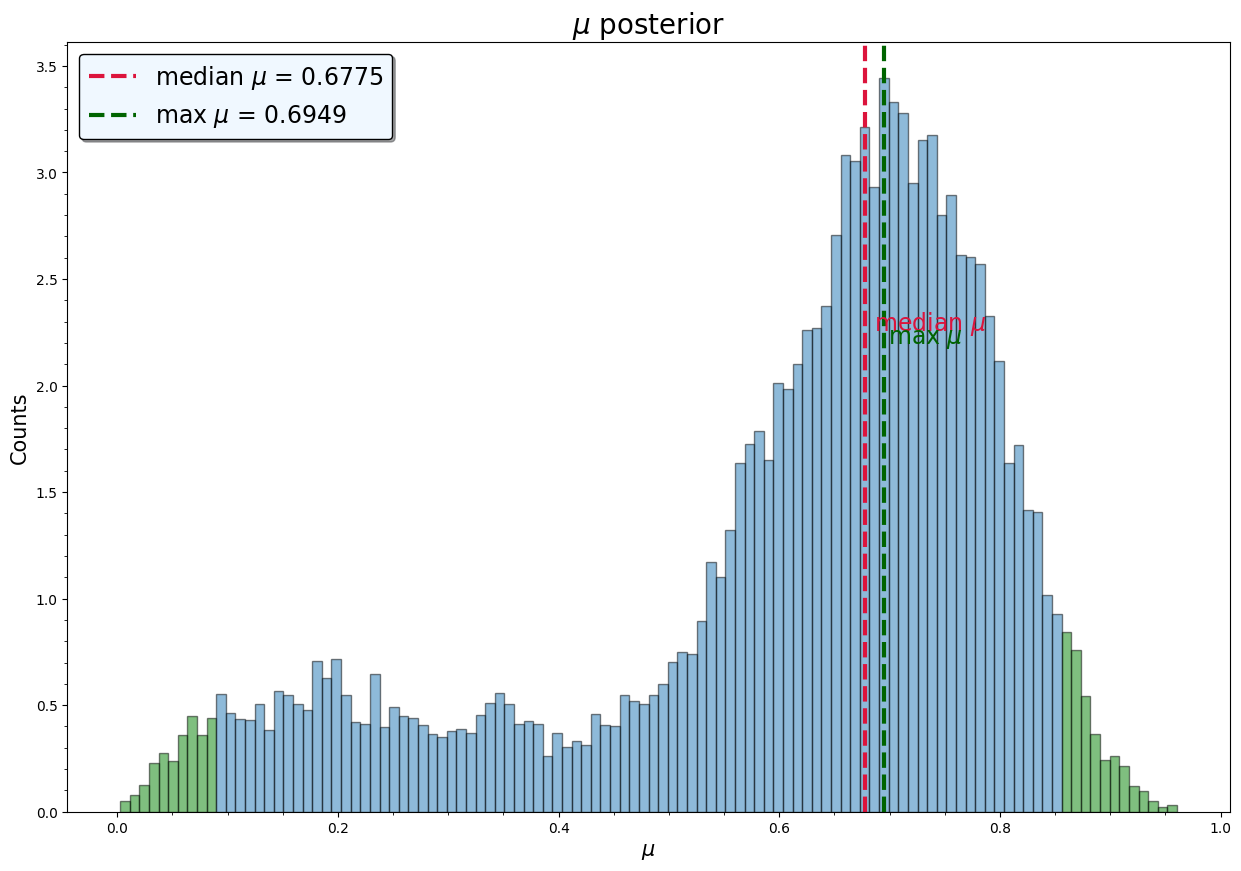

In [ ]:
fig, ax, _, _, max_mu, ci_low_mu, ci_high_mu = plot_funcs.plot_func_sim(
    chain= chain_start_sim, parameter='mu', x_median= 0.008, x_max=0.004, info=False
)

Median value of  $\nu$ : 0.7898
Max value of  $\nu$  : 0.7389
Credibility interval of  $\nu$  : [ 0.5292 , 3.9611 ]


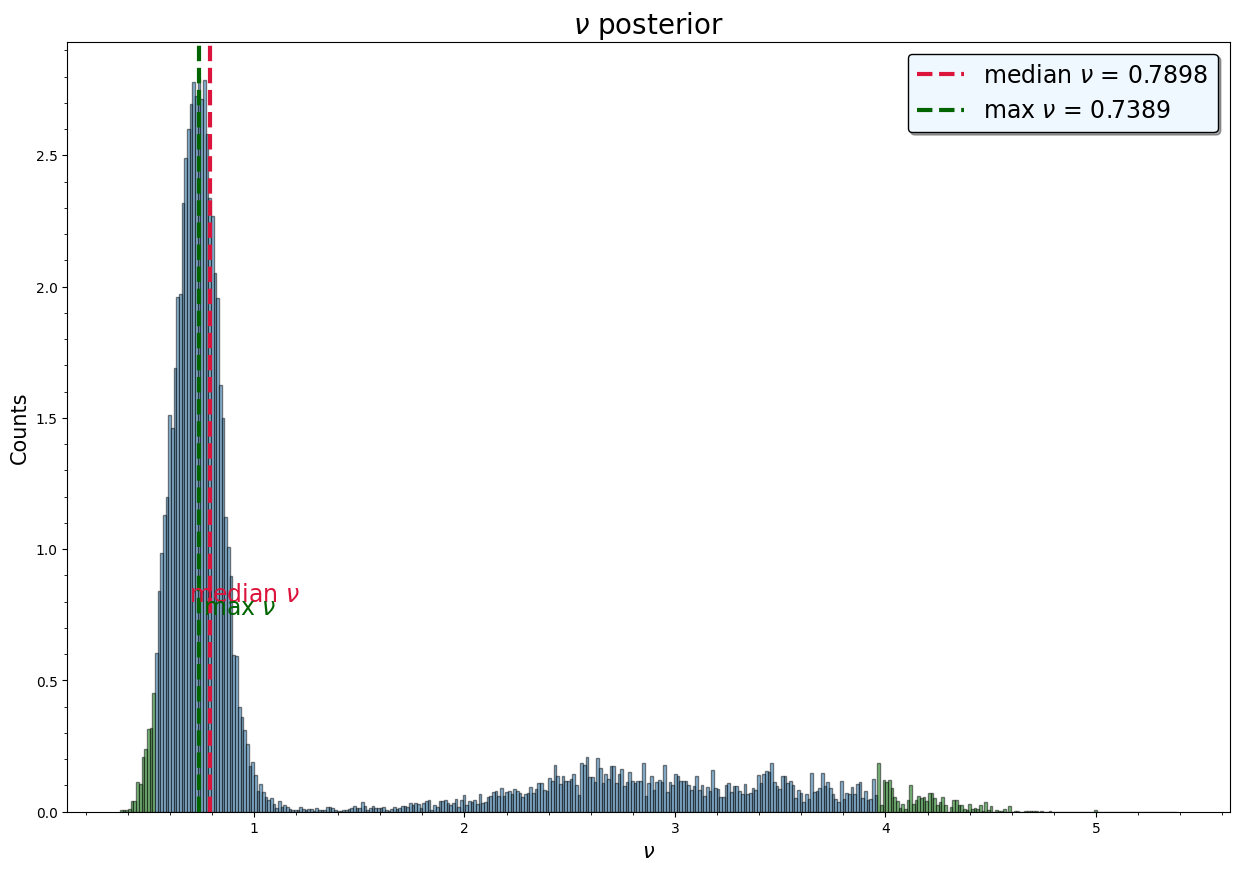

In [ ]:
fig, ax, centers_nu_s_r, counts_nu_s_r, max_nu, ci_low_nu, ci_high_nu = plot_funcs.plot_func_sim(
    chain= chain_start_sim, parameter='nu', y_max=0.75, y_median=0.8, info=False
)

Median value of  a : 15.0034
Max value of  a  : 15.0034
Credibility interval of  a  : [ 12.5695 , 17.5871 ]


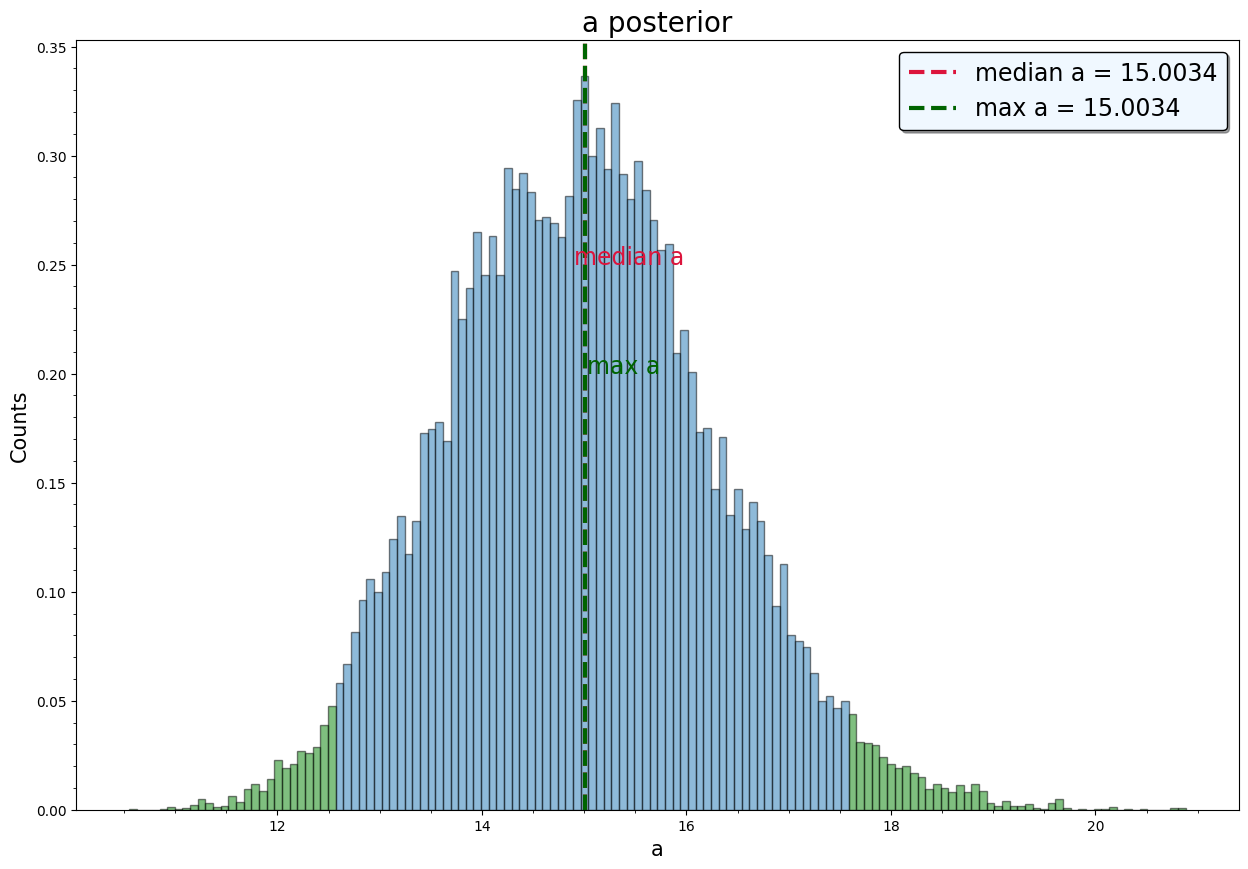

In [ ]:
fig, ax, centers_a_s_r, counts_a_s_r, max_a, ci_low_a, ci_high_a = plot_funcs.plot_func_sim(
    chain= chain_start_sim, parameter='a' , y_max=0.2 , y_median= 0.25, info=False
)

Median value of  b : 15.0044
Max value of  b  : 15.0044
Credibility interval of  b  : [ 12.5909 , 17.6339 ]


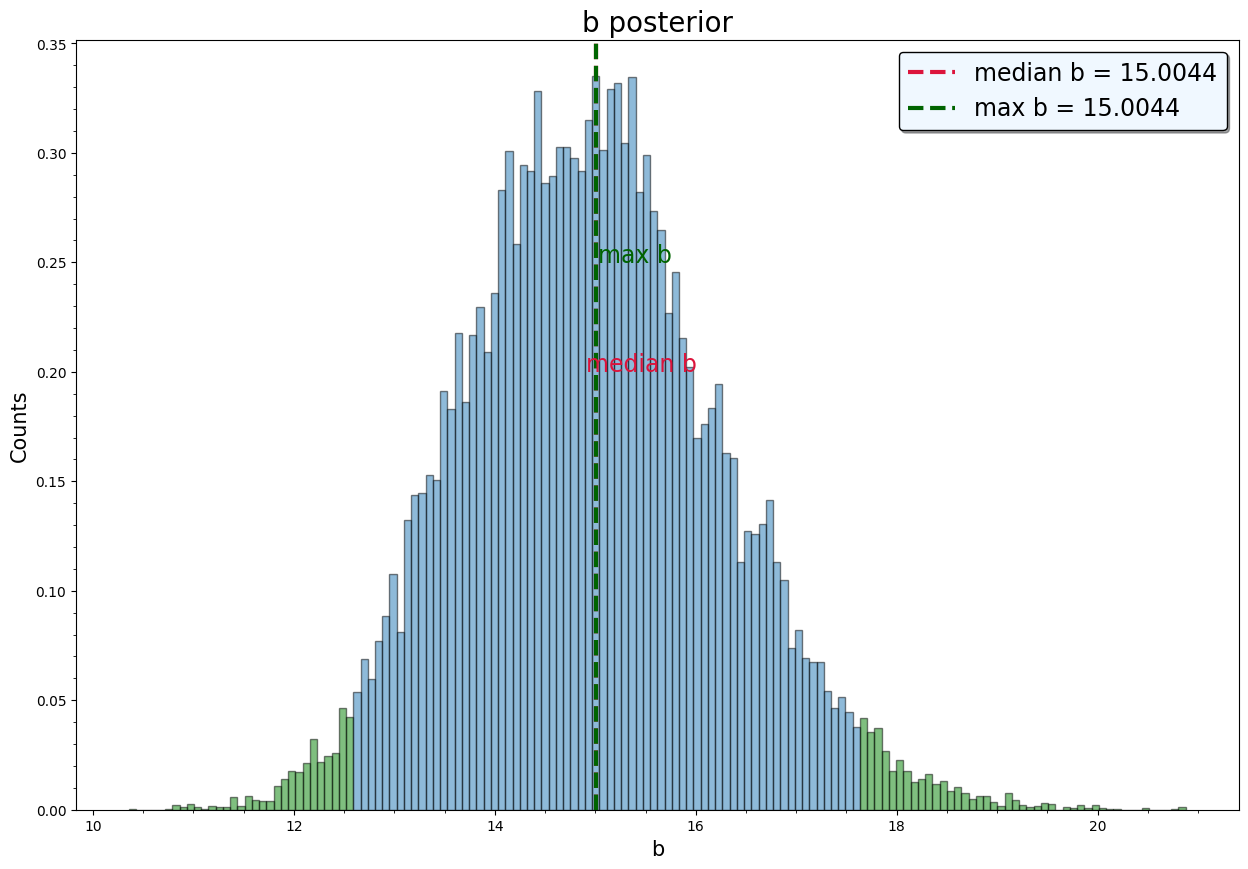

In [ ]:
fig, ax, centers_b_s_r, counts_b_s_r, max_b, ci_low_b, ci_high_b = plot_funcs.plot_func_sim(
    chain= chain_start_sim, parameter='b', y_max=0.25, y_median=0.2, info=False
)

Median value of  c : 30.7799
Max value of  c  : 30.6557
Credibility interval of  c  : [ 26.4949 , 34.9407 ]


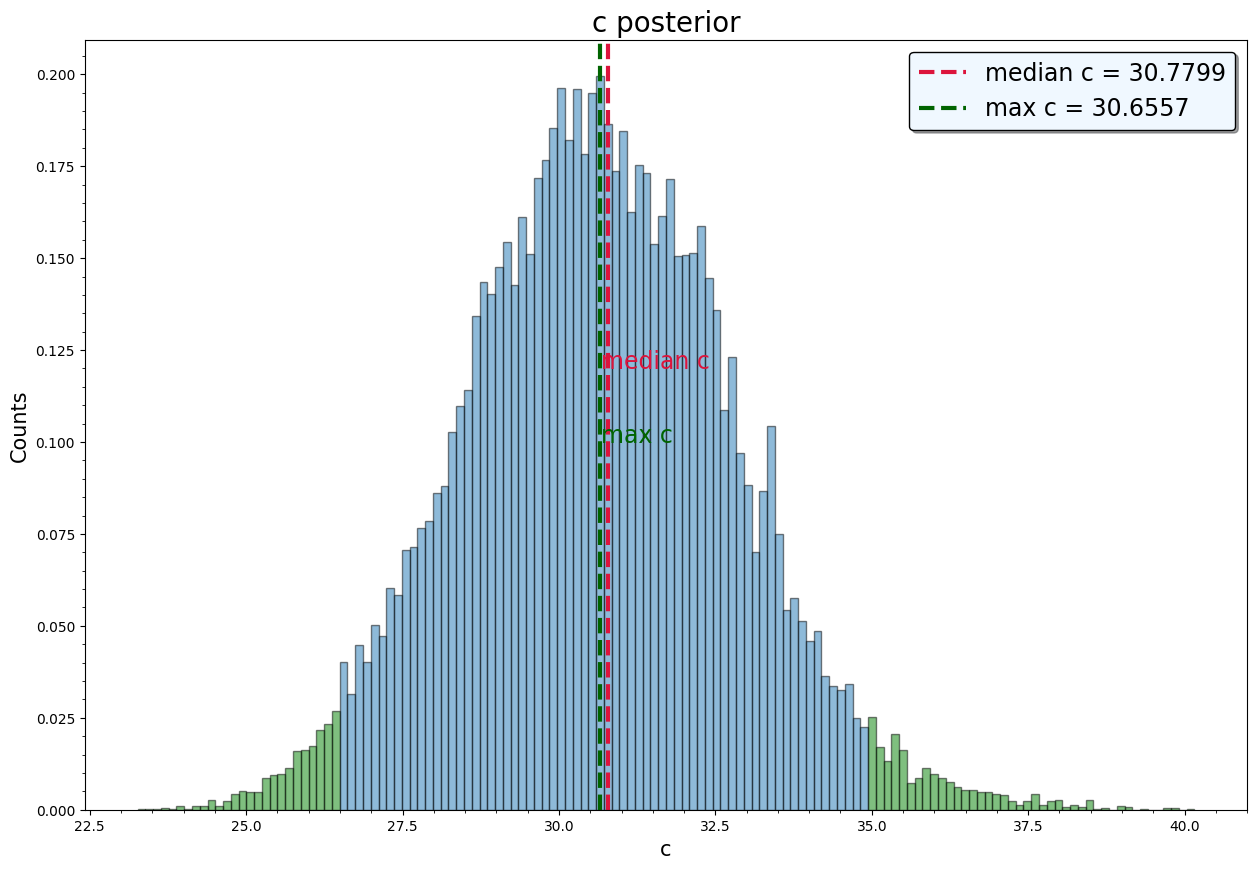

In [ ]:
fig, ax, centers_c_s_r, counts_c_s_r, max_c, ci_low_c, ci_high_c = plot_funcs.plot_func_sim(
    chain= chain_start_sim,  parameter='c', y_max=0.1, y_median=0.12, info=False
)

Median value of  d : 0.046
Max value of  d  : 0.0461
Credibility interval of  d  : [ 0.0399 , 0.0527 ]


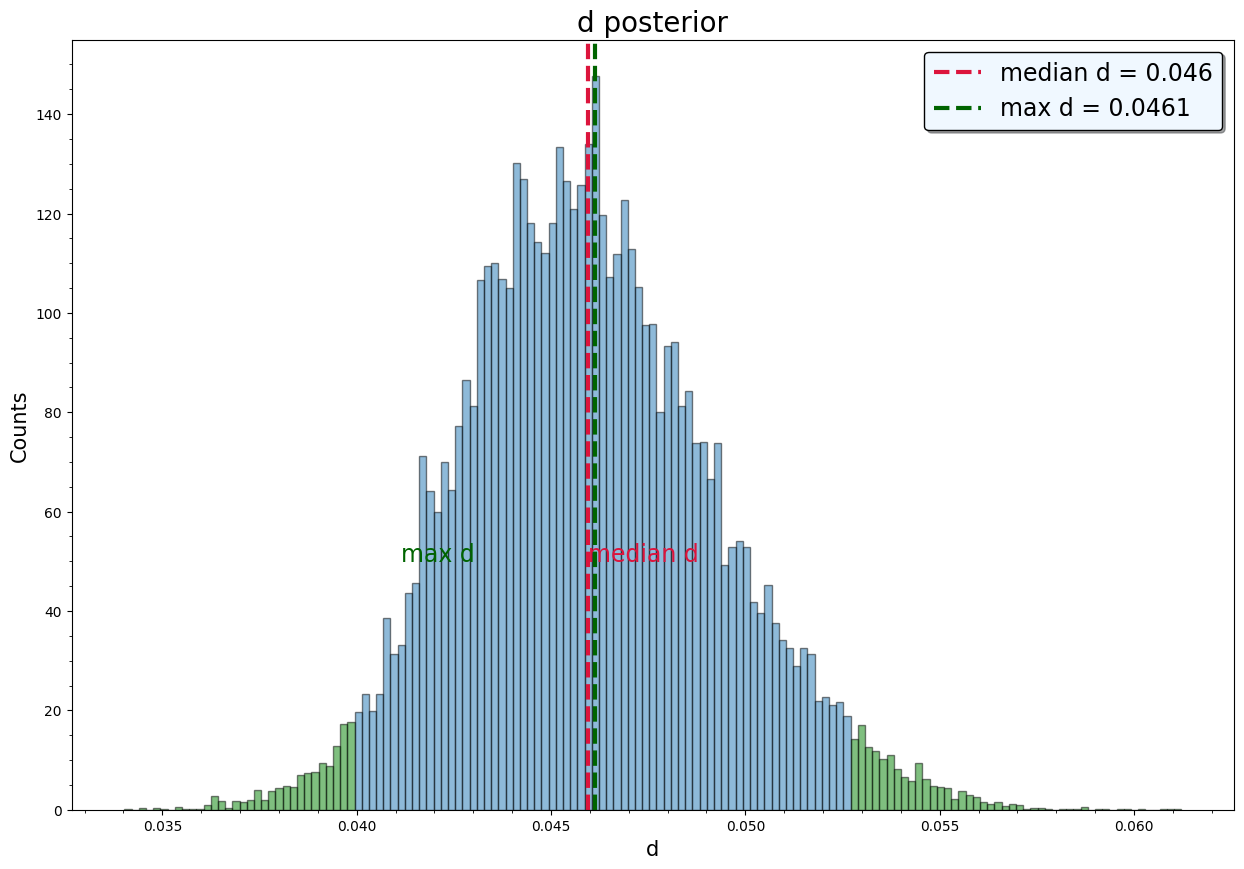

In [ ]:
fig, ax,centers_d_s_r, counts_d_s_r, max_d, ci_low_d, ci_high_d = plot_funcs.plot_func_sim(
    chain= chain_start_sim, parameter='d', x_max=-0.005, x_median=0, y_max=50, y_median=50, info=False
)

In [ ]:
# create file with the results of the inference
filepath = '../data/model0.csv'
create_file = True

if create_file:
    df_mod0 = pd.DataFrame({'omega_2': [max_omega2, ci_low_omega2, ci_high_omega2],
                       'mu':[max_mu, ci_low_mu, ci_high_mu],
                       'nu':[max_nu, ci_low_nu, ci_high_nu],
                       'a':[max_a, ci_low_a, ci_high_a],
                       'b':[max_b, ci_low_b, ci_high_b],
                       'c':[max_c, ci_low_c, ci_high_c],
                       'd':[max_d, ci_low_d, ci_high_d]})
    df_mod0.to_csv(filepath, index=False)

df_mod0 = df_mod0.round(4).rename({0: 'PosteriorMax',
                          1: 'LowerBoundCI',
                          2: 'UpperBoundCI'})

display(df_mod0)

omega_2      mu      nu        a        b        c       d
PosteriorMax   2.5461  0.6949  0.7389  15.0034  15.0044  30.6557  0.0461
LowerBoundCI   0.4402  0.0897  0.5292  12.5695  12.5909  26.4949  0.0399
UpperBoundCI   3.4132  0.8560  3.9611  17.5871  17.6339  34.9407  0.0527

## Chains

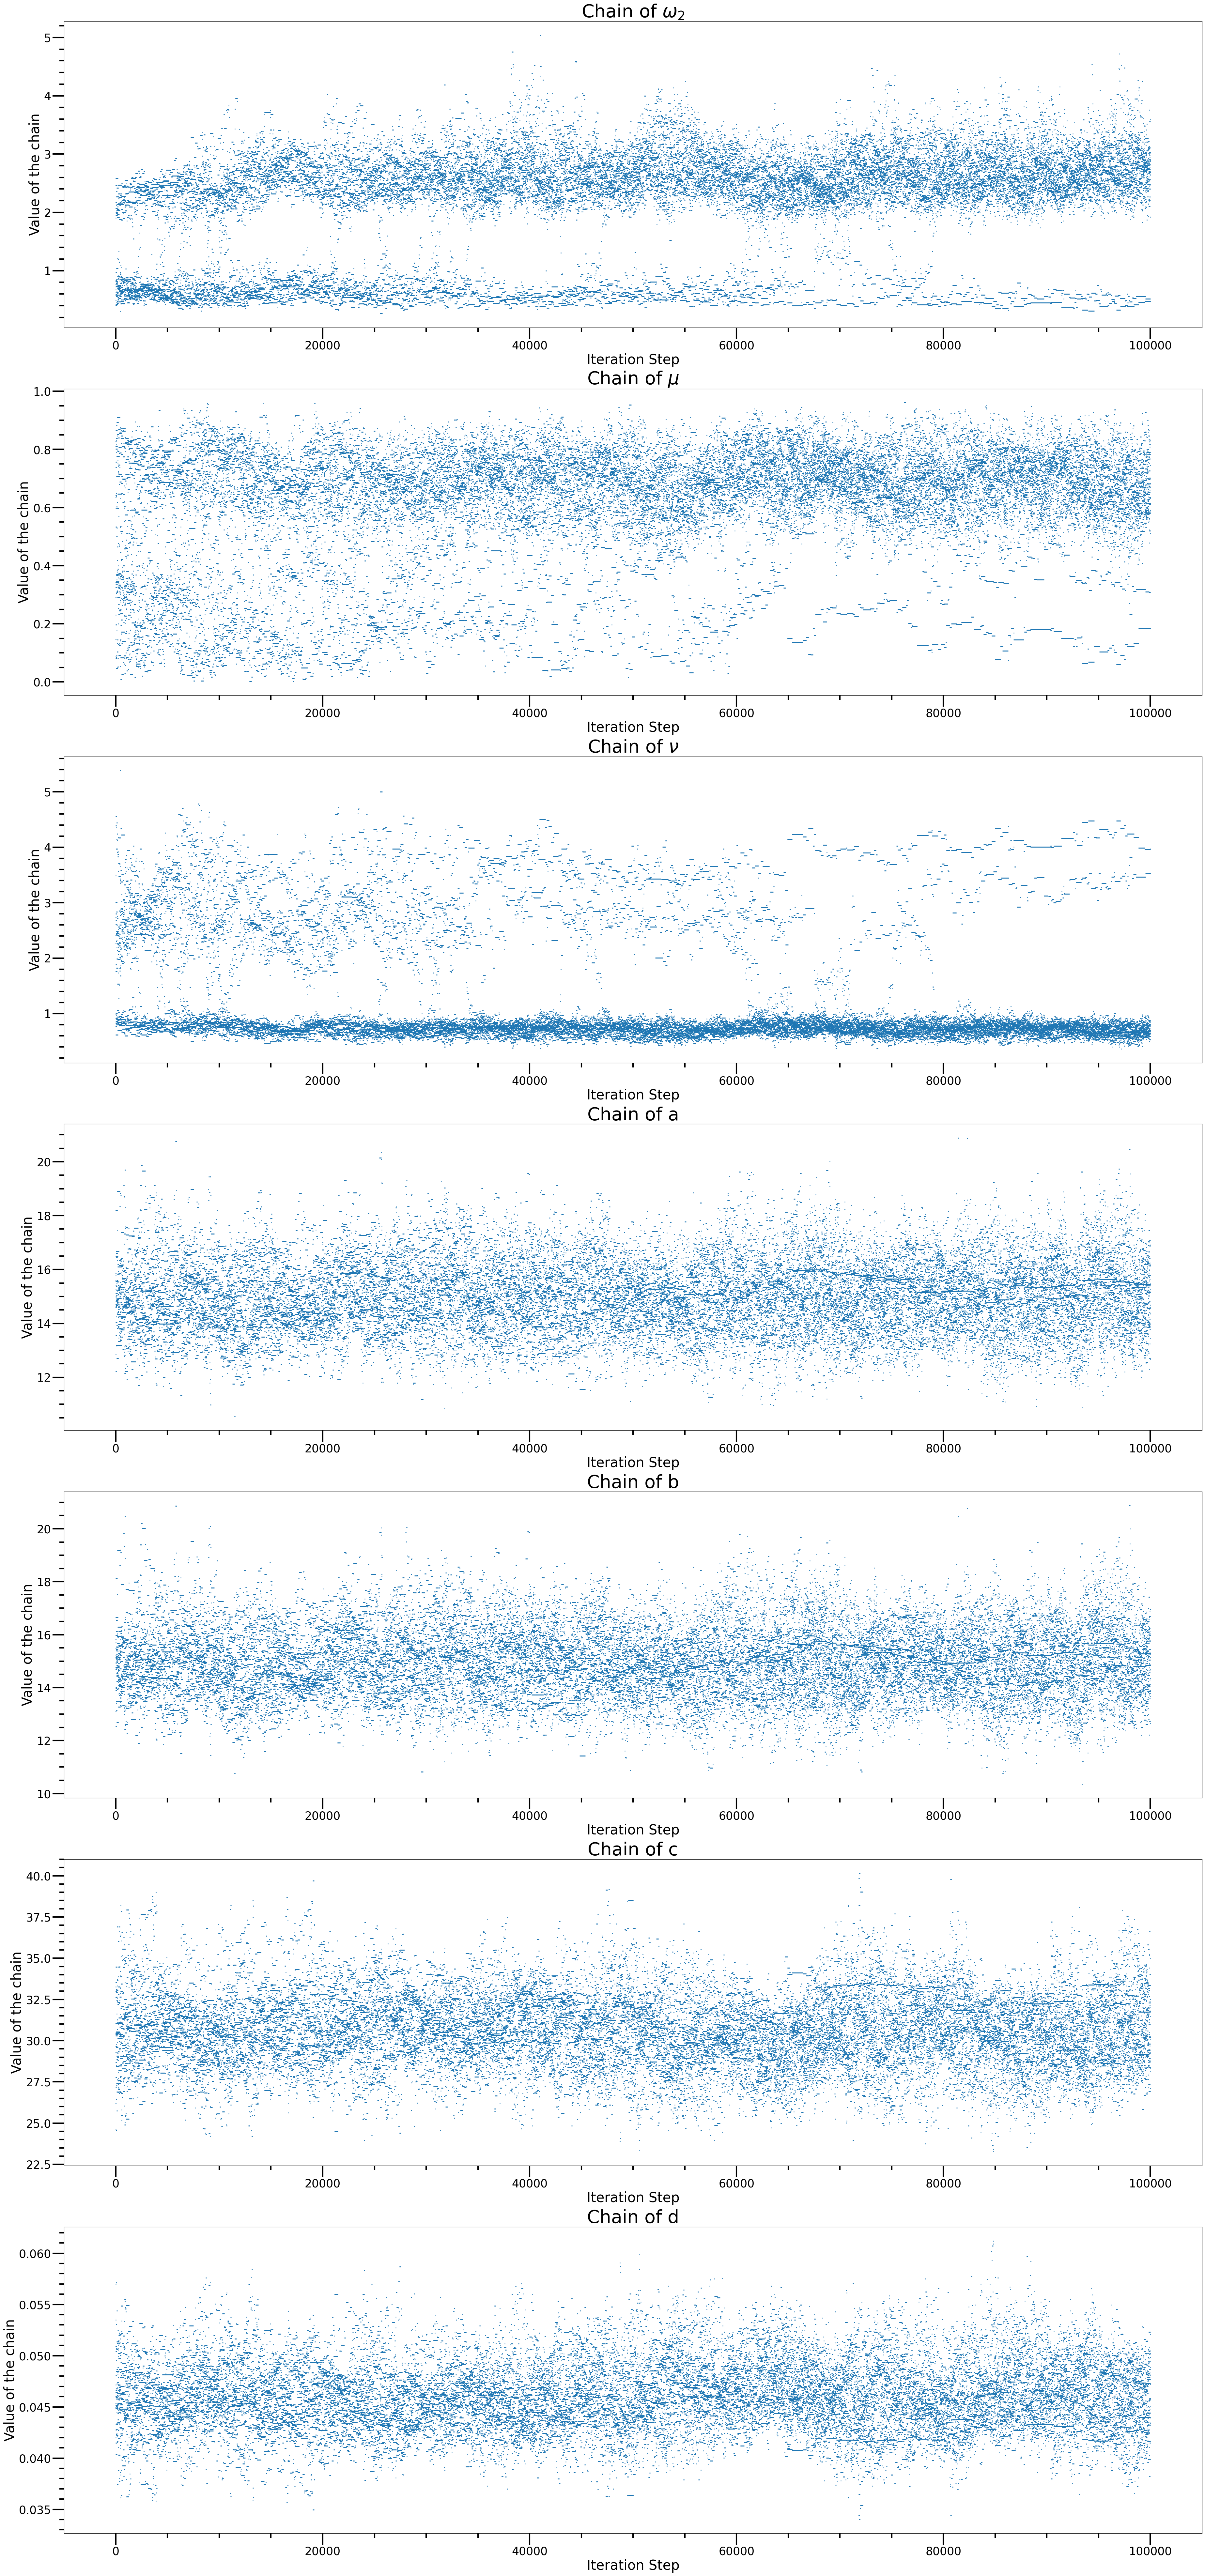

In [ ]:
plot_funcs.chains_plot(chain_start_sim, info=False)
fig.tight_layout(pad=15.0)

## Simulation of the time series
Simulation of the time series using the inferred values of the parameters.

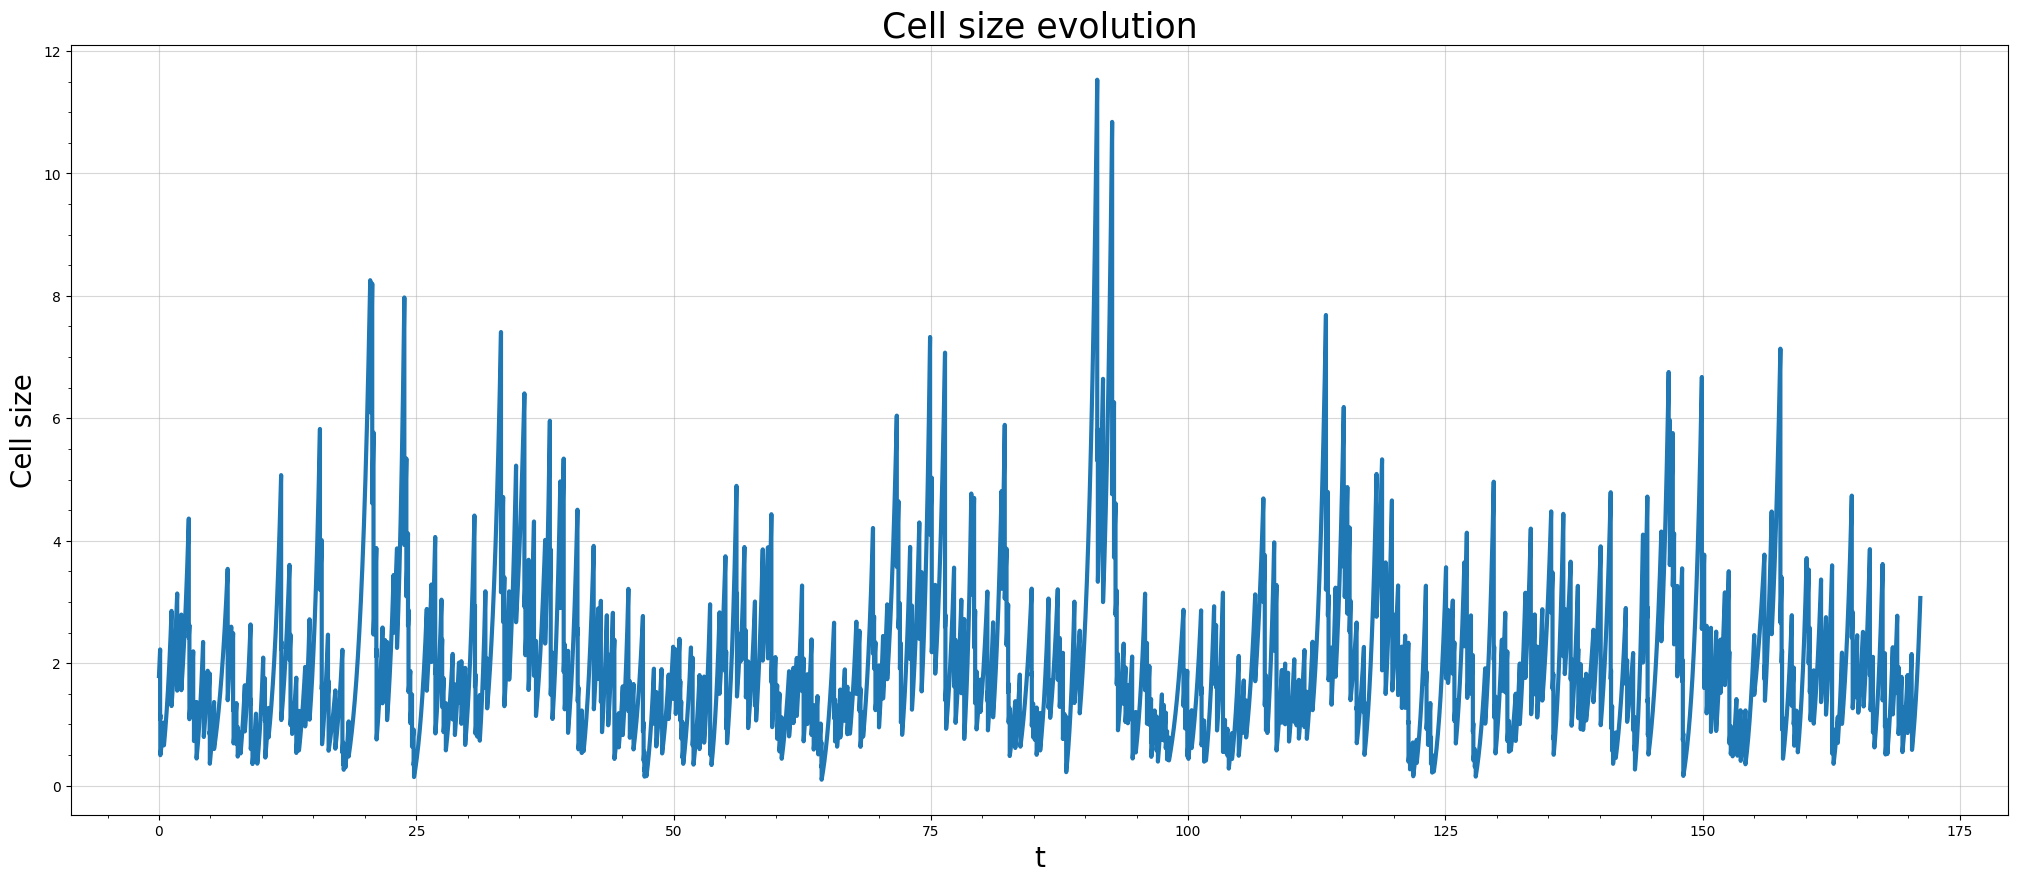

In [ ]:
# simulate the time series
sim_t_starting, all_times_starting, cell_sizes_starting, frac_starting, omg1_starting = functions.sim_t_draw(
    log_CDF=functions.log_CDF_start, 
    x_function=functions.x_function_start, 
    size=500, 
    points_per_evolution=100, 
    xb=xb_realdata, 
    model = 's', 
    pars_new=(max_omega2, max_mu, max_nu, max_a, max_b, max_c, max_d)      
)

fig, ax = plot_funcs.plot_evol(all_times=all_times_starting, cell_sizes=cell_sizes_starting)

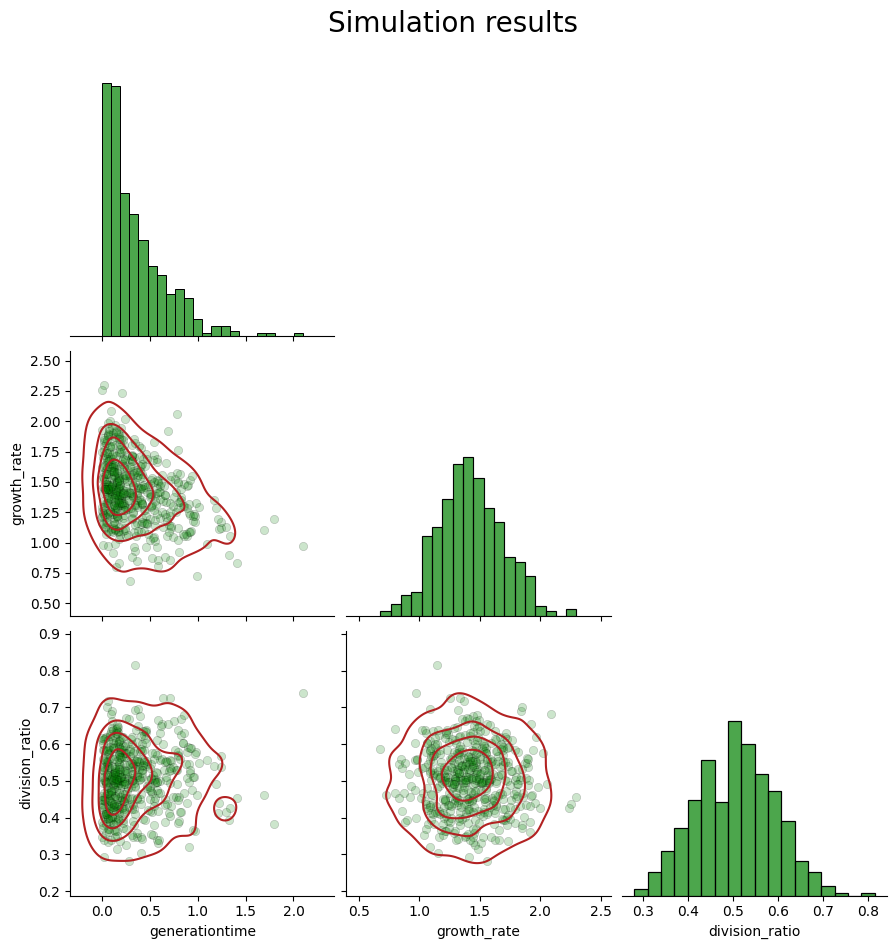

In [ ]:
df_sim_starting = pd.DataFrame()
df_sim_starting['generationtime'] = sim_t_starting
df_sim_starting['growth_rate'] = omg1_starting
df_sim_starting['division_ratio'] = frac_starting


g = sns.pairplot(
    df_sim_starting, diag_kind="hist", corner=True, 
    plot_kws={'color':'green', 'edgecolor':'black', 'alpha':0.2}, diag_kws={'color':'green', 'alpha':0.7}, height=3
)
g.map_lower(sns.kdeplot, levels=5, color="firebrick")

plt.savefig('../images/pairplot_model0.png')

g.fig.suptitle('Simulation results', y=1.05, fontsize=20)
plt.show()


In [ ]:
fig = plot_funcs.plot_3d_interactive(df_sim_starting, real_data_title=False)
fig.show()

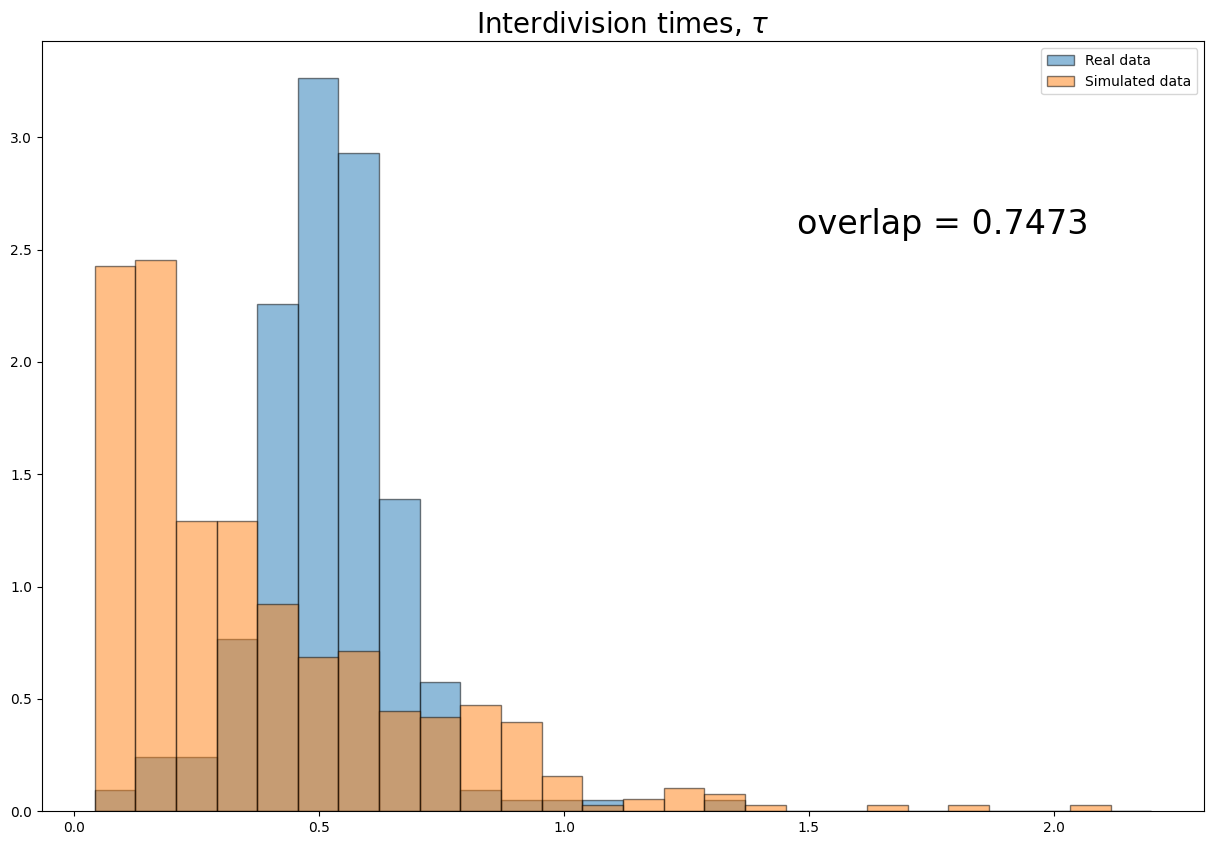

In [ ]:
# overlap metrics between histograms
fig,ax = plot_funcs.overlap_hist(real_data=df_microbial_growth['generationtime'], sim_data=df_sim_starting['generationtime'])

plt.savefig('../images/overlap_model0.png')
plt.show()

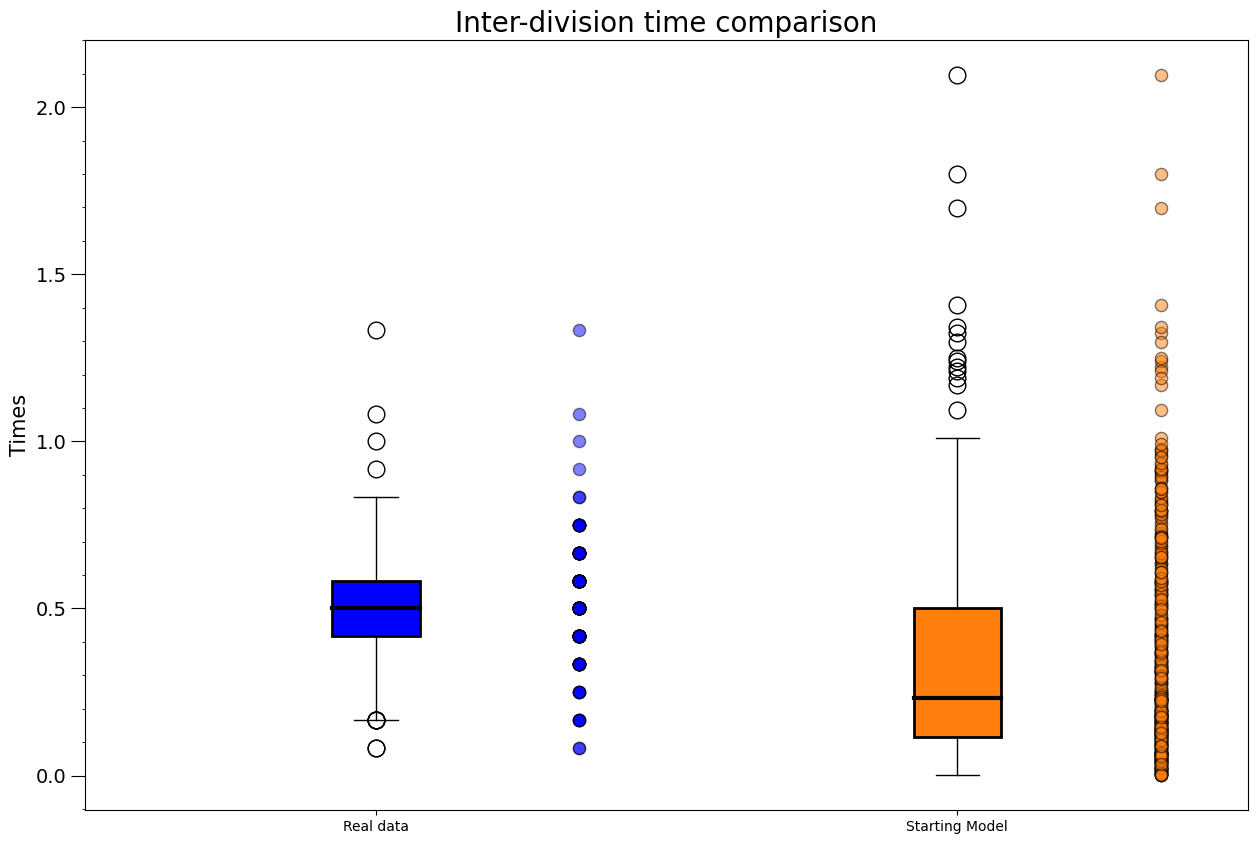

In [ ]:
plot_funcs.boxplot(y=[df_microbial_growth['generationtime'], sim_t_starting], colors=['blue', 'C1'],  title = 'Inter-division time comparison', ylabel= 'Times', xlabel='', x_font= 30, labels=True, list_labels=['Real data', 'Starting Model'] )
plt.show()

## Save the interdivision times in an external file

In [ ]:
# create file with the real data of the division times
filepath = '../data/timeseries.csv'
create_file = True

if create_file:
    df_microbial_growth['generationtime'].rename('real_data').to_csv(filepath, index=False)

In [ ]:
# add the times simulated with the starting model
df = pd.read_csv(filepath)
df['starting_model'] = df_sim_starting['generationtime']
df.to_csv(filepath, index=False)

## Predictive density for model 0

In [ ]:
N_perm = 10
size_train = int(0.5*size)
log_predD = []

#### Priors

In [ ]:
priors = {
    'mu_nu': prior_mu_nu,
    'omega2': prior_omega2,
    'a': prior_a, 
    'b': prior_b, 
    'c': prior_c, 
    'd': prior_d
}

#### EMCEE initializations

In [ ]:
n_walkers = 20

# initial state
p0_omega_2 =np.random.uniform(low=0.5, high=1.2, size=n_walkers).reshape(-1, 1)
p0_mu = np.random.uniform(low=0.01, high=0.15, size=n_walkers).reshape(-1, 1)
p0_nu = np.random.uniform(low=0.6, high=1.3, size=n_walkers).reshape(-1, 1)
p0_a = np.random.uniform(low=a_beta, high=a_beta+np.sqrt(pcov_b[0,0]), size=n_walkers).reshape(-1,1)
p0_b = np.random.uniform(low=b_beta , high=b_beta+np.sqrt(pcov_b[1,1]), size=n_walkers).reshape(-1,1)
p0_c = np.random.uniform(low=c_gamma , high=c_gamma+np.sqrt(pcov_g[0,0]), size=n_walkers).reshape(-1,1)
p0_d = np.random.uniform(low=d_gamma , high=d_gamma+np.sqrt(pcov_g[1,1]), size=n_walkers).reshape(-1,1)

p0 = np.hstack([p0_omega_2, p0_mu, p0_nu, p0_a, p0_b, p0_c, p0_d])

### Cross validation procedure

In [ ]:
log_predD = functions.predictive_density(
    df_microbial_growth,
    size, 
    p0, 
    functions.h_start, 
    functions.CDF_start, 
    priors,
    N_perm=10
)

print("Logarithm of Predictive Density: ", log_predD.mean(), " ± ", log_predD.std())

Logarithm of Predictive Density:  -35.71883418379292  ±  215.67894314270183


In [ ]:
log_predD

array([ 164.34321846,   96.27773447, -100.9561326 ,   41.23319227,
         90.48565256,  102.37797103, -241.82692394,    5.56158417,
       -589.10410926,   74.41947099])

## Save the predictive densities times in an external file

In [ ]:
# create file with the mean predictive density and
# add the predictive densities with the starting model

filepath = '../data/pred_density.csv'
create_file = True

if create_file:
    df = pd.DataFrame({'starting_model': [],
                       'model_1':[],
                       'model_2':[]})
    df.to_csv(filepath, index=False)

# now a file exists
df = pd.read_csv(filepath)
df['starting_model'] = log_predD
df.to_csv(filepath, index=False)

In [ ]:
filepath_scatter = '../data/scatter3d_start.csv'
df_sim_starting.to_csv(filepath_scatter, index=False)

For a comparison of the models we can go back to the **Root notebook: [Microbial_Scaling_Laws](../Microbial_Scaling_Laws.ipynb)**

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=52dba48d-3798-4665-95fc-01a96804955b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>